# Transformer Experiments
I was thinking about how the attention layer in transformers literally just uses linear layers with a couple dot product operations. I wondered if such a process was learnable by a simple neural network, but in my brainstorm sesh with ChatGPT, it didn't like the idea. In the 'Attention is all you need' paper, they talk about how attention sort of reduces the path between dependencies in the input. Like, it allows the input to compare itself *to itself*. So, it's hard to replicate that with linear layers because in order to do so requires a significant amount of depth. Anyways, the key idea here is to make a sort of dot product layer with learnable parameters so that the model has more immediate access (without so much depth required) to compare a set of activations to itself. 

## Baseline
This is GPT-2, hopefully modifiable so that I can swap out its attention. If not, that's just embarrassing.

### prompt

I'm experimenting with a new architecture for a transformer. I only have my rtx 3090 laptop gpu, for now, which has 16gb memory. I'd like to be able to train a transformer, with passable results, just on my machine, so I need a baseline model and dataset which are small enough in resources for me to be able to iterate fairly quickly as I tinker with the model structure. I'd like it to be a decoder-only model, as well. 
Given your constraints, you can start by working with a small-scale decoder-only transformer model and a modestly-sized dataset. Here's a suggestion for the baseline model and dataset:

Baseline Model:
Since you want a decoder-only model, you can use a scaled-down version of GPT-2 as your baseline. The GPT-2 architecture is based on the Transformer architecture and is designed for text generation tasks. To fit your GPU memory, you can reduce the number of layers (transformer blocks) and the hidden size of the model, as well as the number of attention heads.

For example, instead of using the original GPT-2 configuration with 12 layers, 768 hidden units, and 12 attention heads, you could experiment with a smaller model, such as 4 layers, 256 hidden units, and 4 attention heads.

Dataset:
A suitable dataset would be small enough to fit in your GPU memory and enable quick experimentation but still diverse enough to allow your model to learn meaningful representations. One possible option is the "WikiText-2" dataset, a collection of Wikipedia articles containing over 2 million tokens. This dataset is widely used for language modeling tasks and is smaller than the "WikiText-103" dataset.

Training:
To accelerate training, you can use mixed-precision training, which leverages half-precision (float16) arithmetic to reduce memory usage and training time. Additionally, you can experiment with gradient accumulation to further fit your model within the GPU memory constraints.

Remember to start with a smaller batch size and lower learning rate to accommodate your GPU's memory limitations, and gradually increase them if possible. Monitor the training loss and performance on a validation set to ensure that the model is learning effectively.

Once you have established a baseline with the scaled-down GPT-2 model and WikiText-2 dataset, you can start experimenting with your new architecture and compare its performance against the baseline.

### code

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.optim import AdamW


In [2]:
class WikiText2Dataset(Dataset):
    def __init__(self, data_path, tokenizer, seq_length):
        with open(data_path, "r") as file:
            text = file.read()

        self.tokenizer = tokenizer

        # Split the text into smaller chunks and tokenize them
        chunk_size = seq_length * 10
        text_chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
        tokenized_chunks = []

        for chunk in text_chunks:
            tokenized_chunk = tokenizer(chunk, return_tensors="pt", add_special_tokens=True)["input_ids"]
            if tokenized_chunk.size(1) < seq_length:
                tokenized_chunk = torch.cat([tokenized_chunk, torch.zeros(1, seq_length - tokenized_chunk.size(1), dtype=torch.long)], dim=1)
            tokenized_chunks.append(tokenized_chunk)

        # Create input sequences with the specified sequence length
        self.inputs = []

        for tokenized_chunk in tokenized_chunks:
            for i in range(0, tokenized_chunk.size(1) - seq_length, seq_length):
                input_sequence = tokenized_chunk[0, i:i + seq_length]
                self.inputs.append(input_sequence)

        self.inputs = torch.stack(self.inputs)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx]

In [3]:
# Initialize the tokenizer and the dataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
print(f'pad_token: {tokenizer.pad_token}, pad_token_id: {tokenizer.pad_token_id}')
seq_length = 32
train_dataset = WikiText2Dataset("wikitext-2-raw/wiki.train.raw", tokenizer, seq_length)


pad_token: <|endoftext|>, pad_token_id: 50256


In [4]:
# Create a DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Number of training samples:", len(train_dataset))
print("Number of batches:", len(train_loader))

# Define the model configuration and instantiate the GPT-2 model
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=tokenizer.max_model_input_sizes["gpt2"],
    n_ctx=tokenizer.max_model_input_sizes["gpt2"],
    n_embd=256,
    n_layer=4,
    n_head=4,
    activation_function="gelu"
)

model = GPT2LMHeadModel(config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model.to(device)

num_epochs = 3
learning_rate = 2e-4
warmup_steps = 50  # Reduce the warmup steps to ensure the warmup_fraction is within the expected range.

optimizer = AdamW(model.parameters(), lr=learning_rate)
print(f'train_loader length: {len(train_loader)}')
warmup_fraction = warmup_steps / (len(train_loader) * num_epochs)
print("Warmup fraction:", warmup_fraction)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, total_steps=len(train_loader) * num_epochs, pct_start=warmup_fraction)


Number of training samples: 16210
Number of batches: 2027
train_loader length: 2027
Warmup fraction: 0.0082223318533136


In [5]:
# # Train the model
# model.train()
# max_token_index = max([token for batch in train_loader for seq in batch for token in seq])
# print("Max token index in the dataset:", max_token_index)
# print("Tokenizer vocab size:", tokenizer.vocab_size)

# for epoch in range(num_epochs):
#     for step, batch in enumerate(train_loader):
#         inputs = batch.to(device)
#         # print("Input shape:", inputs.shape)
#         # print("Inputs:", inputs)
#         outputs = model(inputs, labels=inputs)
#         loss = outputs.loss

#         loss.backward()
#         optimizer.step()
#         scheduler.step()
#         optimizer.zero_grad()

#         if step % 100 == 0:
#             print(f"Epoch: {epoch + 1}, Step: {step}, Loss: {loss.item()}")

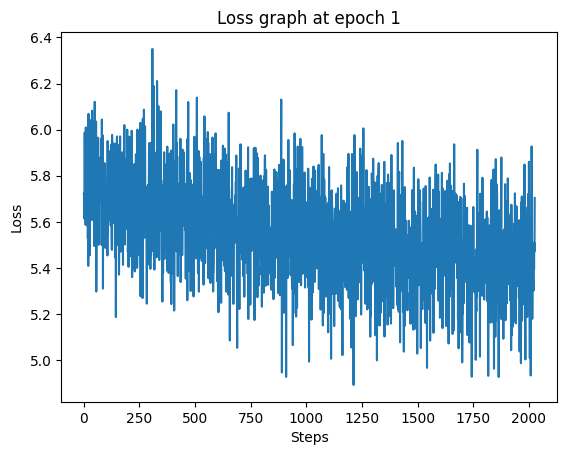

KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

def plot_loss_graph(losses, epoch):
    clear_output(wait=True)  # Clear the output of the current cell
    plt.plot(losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title(f"Loss graph at epoch {epoch}")
    plt.show()

def generate_sample(model, tokenizer, prompt, max_length=50):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    # attention_mask = (input_ids != tokenizer.pad_token_id).to(device)  # Create the attention mask
    with torch.no_grad():
        # output_ids = model.generate(input_ids, max_length=max_length, attention_mask=attention_mask)  # Pass the attention mask to the model
        output_ids = model.generate(input_ids, max_length=max_length)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)


# Train the model
model.train()
losses = []

# Check if pad_token_id is set and set it to 0 if not
# if tokenizer.pad_token_id is None:
#     print("Setting pad_token_id to 0")
#     tokenizer.pad_token_id = 0

for epoch in range(num_epochs):
    for step, batch in enumerate(train_loader):
        input_ids = batch.to(device)
        # print(f'pad_token_id: {tokenizer.pad_token_id}, input_ids: {input_ids}, input_ids != tokenizer.pad_token_id: {input_ids != tokenizer.pad_token_id}')
        # boolean_mask = input_ids != tokenizer.pad_token_id  # Create a boolean mask
        # attention_mask = boolean_mask.type_as(input_ids).to(device)  # Convert the boolean mask to a long tensor and move it to the device
        
        # outputs = model(input_ids, labels=input_ids, attention_mask=attention_mask)  # Pass the attention mask to the model

        outputs = model(input_ids, labels=input_ids)

        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        losses.append(loss.item())

    plot_loss_graph(losses, epoch + 1)



# Plot the final loss graph
plot_loss_graph(losses, 'Final')

# Generate a sample inference
model.eval()
prompt = "In a shocking turn of events,"
generated_text = generate_sample(model, tokenizer, prompt)
print(f"Generated text: {generated_text}")


## Experiment Time!
I've created a Dot Product Interaction Layer, which aims to provide that functionality to compare one set of activations with itself or others directly. Attention seems like it does that. So, I hope that attention emerges from the usage of this layer. I'm going to try to use it in the transformer used above and see what happens.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DotProductInteractionLayer(nn.Module):
    def __init__(self, input_dim, threshold=0.0):
        super(DotProductInteractionLayer, self).__init__()
        self.input_dim = input_dim
        self.threshold = threshold
        self.interaction_matrix = nn.Parameter(torch.randn(input_dim, input_dim))

    def forward(self, x):
        # Compute the absolute interaction matrix
        abs_interaction_matrix = torch.abs(self.interaction_matrix)
        
        # Apply thresholding to the interaction matrix
        threshold_mask = (abs_interaction_matrix > self.threshold).float()
        thresholded_interaction_matrix = abs_interaction_matrix * threshold_mask
        
        # Compute the dot product between the input activations and the thresholded interaction matrix
        interaction_result = torch.matmul(x, thresholded_interaction_matrix)
        
        # Combine the interaction result with the original input (element-wise multiplication or addition)
        combined_result = x * interaction_result  # element-wise multiplication
        # combined_result = x + interaction_result  # element-wise addition
        
        return combined_result

# Example usage
input_dim = 10
batch_size = 5
threshold = 0.5
x = torch.randn(batch_size, input_dim)
layer = DotProductInteractionLayer(input_dim, threshold)
output = layer(x)

print(output.shape)  # Output should have the same shape as input: (batch_size, input_dim)


torch.Size([5, 10])
